# Practical quantum mechanics using computers

The standard approach to learning quantum mechanics (QM) involves a fair amount of theory, with some relatively simple pen-and-paper calculations once the theory has been introduced.  But the vast majority of practical QM calculations are done numerically, using a computer.  This series of ipython notebooks is designed to show you how this works, and to give you the ability to do these calculations for yourself.  They should deepen your understanding of how QM works.
In this notebook, we will be setting up some basic python functions to allow you to calculate the energies of arbitrary states in an infinite square well; these functions will then be used when we change the basis set, and change the potential.

The rough flow of all these QM calculations will be:

* Choose and define a basis set
* Define the potential in the well (either as a function or by values on a grid)
* Create the Hamiltonian matrix
* Diagonalise (using libraries) to give eigenvalues and eigenvectors
* Display the results

Before we write any of the code, we need to import the basic libraries that we will be using (numpy, matplotlib). IPython provides a convenient shortcut for doing this in one go:

In [1]:
# Import matplotlib and numpy libraries and set up in-line plotting.
%pylab --no-import-all inline
# Writing np.pi instead of pi is annoying. Same for sin etc.
from numpy import pi, sin, sqrt
# Make printed representation of matrices visually appealing
np.set_printoptions(precision=3, linewidth=110, suppress=True)

Populating the interactive namespace from numpy and matplotlib


TODO TODO TODO This probably belongs somewhere else


In general, if we have a basis set $\vert\phi_i\rangle, i=1\rightarrow N$, we write the Hamiltonian matrix element between two basis functions as:

$$
H_{ij} = \langle \phi_i\vert\hat{H}\vert\phi_j\rangle
$$

Typically these matrix elements are found by integration on a grid in real space, though there are many other approaches (and some operators and functions where this is not possible).  Remember that the indices $i$ and $j$ in $H_{ij}$ are *arbitrary*: that is, they can each take on any of the values from $1$ to $N$.

## The eigenbasis

The simplest (but least illustrative !) basis set to use is that of the eigenvectors for the system.  For the square well, these are very simple to deduce (they are identical to the solutions for waves on a classical string fixed at both ends).  If we define the potential to be $V(x) = 0, 0 < x < a; V(x) = \infty, x>a; V(x) = \infty, x<0$, then the eigenvectors are:

$$
\phi_n(x) = A\sin\left(\frac{n\pi x}{a}\right), n=1, 2, 3, \ldots
$$

It will be most convenient for us to define the sinusoids in terms of the width of the well and the number of half-periods that fit into the well. Comparing the above form  to the canonical sinusoidal form

$$A\sin(kx+\phi)$$

we conclude that $k = n\pi/a$. Furthermore, we observe that taking derivatives of sinusoids

$$\frac{\mathrm{d}\sin(kx+\phi)}{\mathrm{d}x} = k\sin(kx+\phi+\pi/2)$$

has two effects:

1. adjusting the phase by $\pi/2$
2. multiplying the amplitude by $k$

Therefore we write a general function for generating sinusoids and their derivatives as:

In [2]:
def sinusoid(x, half_periods=2, width=1, amplitude=1, derivative=0, phase=0):
    A, a, n = amplitude, width, half_periods
    k = n * pi / a
    derivative_phase = (pi/2) *  derivative
    derivative_A     =     k  ** derivative # a ** b means 'a to the power of b'
    return A * derivative_A * sin(k*x + phase + derivative_phase)

Next we define the (1-dimensional) grid on which we will be doing our calculations. It's a linearly, equally distributed set of points from 0 to 1:

In [3]:
width = 1.0
num_x_points = 101
x = np.linspace(0,width,num_x_points)
dx = width / (num_x_points - 1)

We can now evaluate `sinusoid` on this grid and plot the result.

You should play around with the arguments to `sinusoid` and plot the resulting shapes, in order to make sure you understand its behaviour. Change the arguments to `sinusoid` in the following cell and evaluate it. Here are a few suggestions

+ `sinusoid(x, width=1)`
+ `sinusoid(x, width=2)`
+ `sinusoid(x, width=0.5)`
+ `sinusoid(x, phase=pi)`
+ `sinusoid(x, phase=pi/4)`
+ `sinusoid(x, phase=pi/2)`
+ `sinusoid(x)`
+ `sinusoid(x, 1)`
+ `sinusoid(x, 3)`
+ `sinusoid(x, 4)`
+ `sinusoid(x, derivative=1)`
+ `sinusoid(x, derivative=2)`
+ `sinusoid(x, derivative=3)`
+ `sinusoid(x, derivative=4)`
+ `sinusoid(x, amplitude=10, half_periods=9, width=10)`

Don't be afraid to try your own ideas.

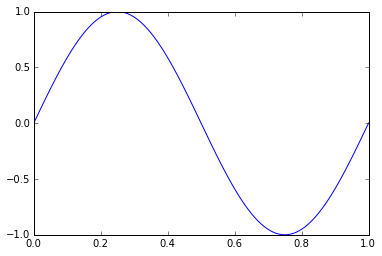

In [4]:
plt.plot(x, np.array(sinusoid(x)));

Have you noticed that our `sinusoid` function returns a single number when its `x` parameter is a single number, and that it returns a numpy array when its `x` parameter is a numpy array? Get used to this magical behaviour in Python and numpy, and be ready to take advantage of it when the opportunity presents itself!

Now let's use our `sinusoid` function to create a collection of eigenstates (and their second derivatives) for the infinite square well. These will be used repeatedly in the notebooks that follow.

First we need to learn about a neat Python feature called *list comprehensions*. They provide a concise way of creating collections. Here we use a list comprehension to create a collection of the squares of the integers from 1 to 5:

In [5]:
[ a*a for a in range(1,6) ]

[1, 4, 9, 16, 25]

List comprehensions can be nested to make collections that resemble matrices. Here we use nested list comprehensions to create a matrix of the products of a few of the first integers:

In [6]:
[ [ a*b for a in range(1,5) ] for b in range(1,4) ]

[[1, 2, 3, 4], [2, 4, 6, 8], [3, 6, 9, 12]]

The collections created using list comprehensions can serve as a source of initial values for numpy arrays:

In [7]:
np.array([ [ a*b for a in range(1,5) ] for b in range(1,4) ])

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12]])

Don't forget to try your own variations: just modify the code in an input cell and press CONTROL-ENTER to see how it behaves!

Recall that Python dictionaries are data structures which map *keys* to *values*. Here is a dictionary which maps the first four natural numbers to their squares

In [8]:
squares = {}
squares[1] =  1
squares[2] =  4
squares[3] =  9
squares[4] = 16
print "The whole dictionary looks like this:", squares
print "And here is the value associated with the key 3:", squares[3]

The whole dictionary looks like this: {1: 1, 2: 4, 3: 9, 4: 16}
And here is the value associated with the key 3: 9


Above, we created an empty dictionary and added key-value pairs into it, one by one. We can create an identical dictionary in one go, using the literal syntax for dictionaries:

In [9]:
squares = {1: 1, 2: 4, 3: 9, 4: 16}
print "The whole dictionary looks like this:", squares
print "And here is the value associated with the key 3:", squares[3]

The whole dictionary looks like this: {1: 1, 2: 4, 3: 9, 4: 16}
And here is the value associated with the key 3: 9


Finally, we could have created the dictionary with a dictionary comprehension. If you understood list comprehensions, this should be fairly obvious:

In [10]:
squares = { n:n*n for n in range(1,5) }
print "The whole dictionary looks like this:", squares
print "And here is the value associated with the key 3:", squares[3]

The whole dictionary looks like this: {1: 1, 2: 4, 3: 9, 4: 16}
And here is the value associated with the key 3: 9


We will use list comprehensions with our `sinusoid` function to create our collections of eigenstates and their derivatives. We will use a dictionary to store the numpy arrays which represent our functions and their derivatives: the `n`th derivative of a function will be stored in the dictionary under the key `n`. Given that we are only interested in the zeroth and second derivative, we will only store keys `0` and `2`.

In [11]:
number_of_base_states = 10
unnormalised_eigenbases = { 0 : [ sinusoid(x,n              ) for n in range(1,number_of_base_states+1) ],
                            2 : [ sinusoid(x,n, derivative=2) for n in range(1,number_of_base_states+1) ] }

Now plot the first few eigenstates; we offset them vertically by adding 3n to make it clearer.

(0, 11)

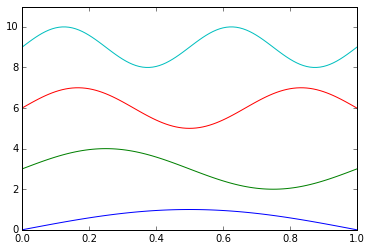

In [12]:
how_many_to_plot = 4
derivative_order = 0
for n,eigenstate in enumerate(unnormalised_eigenbases[derivative_order][:how_many_to_plot]):
    plt.plot(x, eigenstate + 3*n)
plt.ylim((0,11))

Do these make sense ? You should ask yourself if they match the boundary conditions, and if they fit with your expectations of the physical properties of the system.

We should now be confident that our function is correct (it's always worth checking this somehow, whether through plotting the output or a simple test).

Next we will normalise the eigenstates and their derivatites. To do this we need to be able to integrate our eigenstate functions. We'll use a VERY simple integration routine. Much better ones exist.

In [13]:
def integrate(f, dx):
    """Calculate the definite integral of a function approximated by a
    numpy array with spacing dx."""
    return sum(f)*dx

With this, we can calculate the normalisation factors for each of the basis states. These are simply $1/\sqrt{<\phi_n|\phi_n>}$.

In [14]:
normalisations = [ sqrt(1 / integrate(phi_n * phi_n, dx)) for phi_n in unnormalised_eigenbases[0] ]

Then we multiply our bases and their second derivatives by their corresponding factors, to obtain their normalised versions.

In [15]:
normalised_eigenbases = { 0 : [   phi*norm for   (phi,norm) in zip(unnormalised_eigenbases[0], normalisations) ],
                          2 : [ d2phi*norm for (d2phi,norm) in zip(unnormalised_eigenbases[2], normalisations) ] }

A more concise way of expressing exactly the same idea (by replacing the list comprehensions with `map`) is

In [16]:
from operator import mul  # A function that behaves just like the `*` operator
normalised_eigenbases = { 0 : map(mul, unnormalised_eigenbases[0], normalisations) ,
                          2 : map(mul, unnormalised_eigenbases[2], normalisations)}

The statement

    stuff = map(mul, thingies, whatsits)

translated to plain English, reads "`stuff` is a new collection created by elementwise `mul`tiplication of the elements found in `thingies` and `whatsits`".

We could generalise the process to dictionaries containing any collections of derivatives, by using a dictionary comprehension:

In [17]:
normalised_eigenbases = { n : map(mul, functions, normalisations)
                          for (n, functions) in unnormalised_eigenbases.items() }

Next we need to look at column and row vectors from a numpy perspective.

In [18]:
print '--------- A (1x5) matrix representing a row vector ------------'
row = np.array(range(5), ndmin=2)
print row.shape
print row
print '-------- A (5x1) matrix representing a column vector ----------'
col = row.transpose()
print col.shape
print col
print '------- row . col ---------- (1x5) . (5x1) --> (1x1)-----------'
print np.dot(row, col)
print '------- col . row ---------- (5x1) . (1x5) --> (5x5)-----------'
print np.dot(col, row)
print '-------   2 . 3   ----- the same code works for scalars too! --'
print np.dot(2,3)

--------- A (1x5) matrix representing a row vector ------------
(1, 5)
[[0 1 2 3 4]]
-------- A (5x1) matrix representing a column vector ----------
(5, 1)
[[0]
 [1]
 [2]
 [3]
 [4]]
------- row . col ---------- (1x5) . (5x1) --> (1x1)-----------
[[30]]
------- col . row ---------- (5x1) . (1x5) --> (5x5)-----------
[[ 0  0  0  0  0]
 [ 0  1  2  3  4]
 [ 0  2  4  6  8]
 [ 0  3  6  9 12]
 [ 0  4  8 12 16]]
-------   2 . 3   ----- the same code works for scalars too! --
6


This naturally lends itself to implementation of a general function for the calculation of Dirac (bra-ket) notation expressions, which will allow us to calculate almost any interesting physical quantities in our exploration of QM that follows.

There is a little pitfall in the way though. In the above examples our vectors were vectors of numbers, while in our Dirac expressions they will be vectors of eigenstates, which themselves are exprssed as numpy arrays. In the above examples the numpy arrays were 2-dimensional; by storing numpy arrays within them we obtain 3-dimensional numpy arrays, and the behaviour of `np.dot` for more than 2 dimensions is not entirely intuitive, or particularly well-suited to our purposes. To get around the difficulties with `np.dot` we will use `np.einsum` instead: Because the details would distract us unnecessarily, I'll simply provide you with the solution without explanation, then we'll check that it does what we want.

First we create row and column vectors containing the functions described by `normalised_eigenbases`:

In [19]:
phi_bra = { n : np.array(functions, ndmin=3) for (n, functions) in normalised_eigenbases.items() }
phi_ket = { n : array.transpose(1,0,2)       for (n, array)     in phi_bra.              items() }
print "phi_bra contains row    vectors of arrays: ", phi_bra[0].shape, phi_bra[2].shape
print "phi_ket contains column vectors of arrays: ", phi_ket[0].shape, phi_ket[2].shape

phi_bra contains row    vectors of arrays:  (1, 10, 101) (1, 10, 101)
phi_ket contains column vectors of arrays:  (10, 1, 101) (10, 1, 101)


Here is the implementation of our dirac expression evaluator (don't try to understand it on first reading):

In [20]:
def no_op(arg):
    "An operator which does nothing. "
    return arg    

class Missing_dx(Exception): pass
    
def dirac(bra, op_or_ket, ket=None, dx=None, integrate=integrate):
    if dx is None:
        raise Missing_dx("Must provide a dx in call to `dirac`.")
    if ket is None:
        ket = op_or_ket
        op = no_op
    else:
        op = op_or_ket
    return integrate(np.einsum('ij...,jk...', bra, op(ket)), dx)

If the $\phi_n$ really are orthogonal and normalised, then

$$
| \phi_m><\phi_n |
$$

should be an identity matrix. Let's check that our tools reproduce this:

In [21]:
dirac(phi_ket[0], phi_bra[0], dx=dx)

array([[ 1., -0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.],
       [-0.,  1.,  0.,  0.,  0., -0.,  0., -0., -0., -0.],
       [-0.,  0.,  1.,  0.,  0.,  0., -0., -0.,  0.,  0.],
       [-0.,  0.,  0.,  1.,  0.,  0., -0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1., -0.,  0.,  0., -0., -0.],
       [ 0., -0.,  0.,  0., -0.,  1.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0., -0.,  0.,  0.,  1., -0.,  0., -0.],
       [ 0., -0., -0., -0.,  0., -0., -0.,  1., -0.,  0.],
       [ 0., -0.,  0., -0., -0.,  0.,  0., -0.,  1., -0.],
       [-0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  1.]])

Our `dirac` function also allows us to feed operators into the calculation. Let's write the kinetic term of the Hamiltonian first, as it is the simplest:

$$
\mathrm{KE} = -\frac{1}{2}\frac{\mathrm{d}^2\phi_n}{\mathrm{d}x^2}
$$

Remember that we stored the eigenstates in `phi_ket[0]` and their second derivatives in `phi_ket[2]`, so

In [22]:
def KE_term(phi):
    return - phi[2] / 2

The potential term is a little more complicated: On the one hand it must have the same interface as `KE_term` in that it receives the dictionary representing the state functions and their derivatives as its sole argument; on the other hand we must also be able to feed it a specific potential. The solution is to write a factory function which accepts the potential and creates an operator which depends on that potential:

In [23]:
def PE_term(V):
    def PE_term(phi):
        return V * phi[0]
    return PE_term

The Hamiltonian is just the sum of these two. As any specific Hamiltonian also depends on `V` it needs to be written in the same fashion as `PE_term`

In [24]:
def Hamiltonian(V):
    PE = PE_term(V)
    def Hamiltonian(phi):
        return PE(phi) + KE_term(phi)
    return Hamiltonian

In our infinite square well, the potential is zero for every value of $x$ inside the well:

In [25]:
V_flat = np.zeros_like(x)

Constructing a Hamiltonian with this potential and feeding it into `dirac`

In [26]:
dirac(phi_ket[0], Hamiltonian(V_flat), phi_bra,    dx=dx)

array([[   4.935,   -0.   ,    0.   ,   -0.   ,    0.   ,    0.   ,   -0.   ,   -0.   ,    0.   ,    0.   ],
       [  -0.   ,   19.739,   -0.   ,   -0.   ,   -0.   ,    0.   ,   -0.   ,   -0.   ,   -0.   ,   -0.   ],
       [   0.   ,   -0.   ,   44.413,    0.   ,    0.   ,    0.   ,   -0.   ,   -0.   ,    0.   ,    0.   ],
       [  -0.   ,   -0.   ,   -0.   ,   78.957,   -0.   ,   -0.   ,   -0.   ,   -0.   ,   -0.   ,   -0.   ],
       [   0.   ,    0.   ,   -0.   ,   -0.   ,  123.37 ,    0.   ,    0.   ,    0.   ,   -0.   ,    0.   ],
       [  -0.   ,    0.   ,    0.   ,   -0.   ,   -0.   ,  177.653,    0.   ,   -0.   ,   -0.   ,    0.   ],
       [  -0.   ,   -0.   ,   -0.   ,   -0.   ,    0.   ,   -0.   ,  241.805,   -0.   ,    0.   ,   -0.   ],
       [  -0.   ,   -0.   ,   -0.   ,   -0.   ,    0.   ,   -0.   ,   -0.   ,  315.827,   -0.   ,    0.   ],
       [   0.   ,   -0.   ,    0.   ,   -0.   ,    0.   ,    0.   ,    0.   ,   -0.   ,  399.719,    0.   ],
       [  -0.   ,  

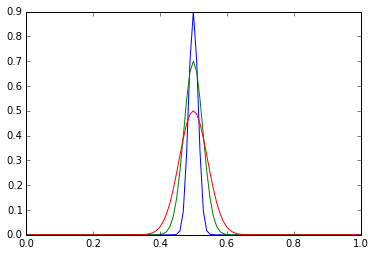

In [27]:
def gaussian(x, mu, sigma):
  return np.exp(-np.power((x - mu)/(2*sigma), 2))

plt.plot(x, 0.9 * gaussian(x, 0.5, 0.01))
plt.plot(x, 0.7 * gaussian(x, 0.5, 0.02))
plt.plot(x, 0.5 * gaussian(x, 0.5, 0.03))

def bump(x, height, half_width):
    mid = x.size // 2
    V = np.zeros_like(x)
    V[mid-half_width : mid+half_width+1] = [height]*(2*half_width+1)
    return V
# plt.plot(x, bump(x, 0.9, 1))
# plt.plot(x, bump(x, 0.7, 5))
# plt.plot(x, bump(x, 0.5, 7))

In [28]:
V_bump = bump(x, 0.5, 1)
dirac(phi_ket[0], Hamiltonian(V_bump), phi_bra,    dx=dx)

array([[   4.965,   -0.   ,   -0.03 ,    0.   ,    0.03 ,    0.   ,   -0.03 ,   -0.   ,    0.029,    0.   ],
       [  -0.   ,   19.739,   -0.   ,   -0.   ,   -0.   ,    0.   ,   -0.   ,   -0.   ,   -0.   ,    0.   ],
       [  -0.03 ,   -0.   ,   44.443,    0.   ,   -0.03 ,    0.   ,    0.029,   -0.   ,   -0.029,    0.   ],
       [  -0.   ,   -0.   ,   -0.   ,   78.957,    0.   ,   -0.   ,   -0.   ,    0.001,   -0.   ,   -0.001],
       [   0.03 ,    0.   ,   -0.03 ,    0.   ,  123.4  ,    0.   ,   -0.029,    0.   ,    0.029,    0.   ],
       [  -0.   ,    0.   ,    0.   ,   -0.   ,   -0.   ,  177.654,    0.   ,   -0.001,   -0.   ,    0.001],
       [  -0.03 ,   -0.   ,    0.029,   -0.   ,   -0.029,   -0.   ,  241.834,   -0.   ,   -0.029,   -0.   ],
       [   0.   ,   -0.   ,   -0.   ,    0.001,    0.   ,   -0.001,   -0.   ,  315.829,   -0.   ,   -0.002],
       [   0.029,   -0.   ,   -0.029,   -0.   ,    0.029,    0.   ,   -0.029,   -0.   ,  399.747,    0.   ],
       [  -0.   ,  

We are ready to calculate the energies:

$$
E_n = <\phi_n | \hat{H} | \phi_n >
$$

where

$$
\hat{H} \phi_n = \frac{-\mathrm{d}^2\phi_n}{\mathrm{d}x^2}
$$

because $\hbar = m = 1$ and $V=0,\ \forall x$ within the well.

In [29]:
# Replace this with something that uses `dirac`
energies_numeric = [ integrate(- phi_n * d2phi_n / 2, dx)
                     for (phi_n, d2phi_n) in zip(normalised_eigenbases[0], normalised_eigenbases[2]) ]

We can also calculate these energies analytically:

$$
E_n = \frac{n^2\pi^2}{2}
$$

In [30]:
energies_analytic = [ n*n*pi*pi/2 for n in range(1, len(normalised_eigenbases)+1) ]

Comparing the numeric and analytic results

In [31]:
for n,(E_n, E_a) in enumerate(zip(energies_numeric, energies_analytic),1):
    print "Energy calculated for eigenstate n = {:2d} is {:17.13f}".format(n, E_n)
    print "Energy expected   for eigenstate n = {:2d} is {:17.13f}".format(n, E_a)

Energy calculated for eigenstate n =  1 is   4.9348022005447
Energy expected   for eigenstate n =  1 is   4.9348022005447
Energy calculated for eigenstate n =  2 is  19.7392088021787
Energy expected   for eigenstate n =  2 is  19.7392088021787


<font color='red'>ASIDE</font>

We can also get these out giving our `dirac` function two kets or two bras around the operator, but I suspect that, officially speaking, this shouldn't work.

In [32]:
print dirac(phi_bra[0], Hamiltonian(V_flat), phi_bra   , dx=dx)
print dirac(phi_ket[0], Hamiltonian(V_flat), phi_ket   , dx=dx)

[[   4.935   19.739   44.413   78.957  123.37   177.653  241.805  315.827  399.719  493.48 ]]
[[   4.935]
 [  19.739]
 [  44.413]
 [  78.957]
 [ 123.37 ]
 [ 177.653]
 [ 241.805]
 [ 315.827]
 [ 399.719]
 [ 493.48 ]]


we see that these numbers agree extremely well ! We would find worse agreement if we used fewer points in our x array (you might like to try this).

## Matrix representation

What about the rest of the Hamiltonian matrix? We will want to caluclate such matrices for different potentials in later notebooks, so it's worth investing a little effort in producing a general utility for calculating them.

Recall that we write the Hamiltonian matrix element between two basis functions as:

$$
H_{ij} = \langle \phi_i\vert\hat{H}\vert\phi_j\rangle
$$

Here is a Python utility which allows us to build matrices with these elemets, for any arbitrary operator and sets of basis functions (and their second derivatives).

It should not surprise you that the matrix is diagonal: because the basis vectors are eigenvectors, an operator acts on a basis vector and returns that basis vector multiplied by the relevant eigenvalue.  The orthogonality of the basis then ensures that only the diagonal elements are non-zero.

Of course, we can choose other basis vectors than the eigenvectors.  In these cases, the matrix will *not* be diagonal.  We will look at this in a subsequent notebook.

Once we have the Hamiltonian (or any observable matrix) we can find the eigenvalues and eigenvectors from the matrix.  There are many approaches to this, but we will rely on the built-in `numpy` routines in `numpy.linalg`: `eigh` for a Hermitian matrix (or just `eig` for a non-Hermitian matrix).

## Overall procedure

In general, when using the matrix approach to quantum mechanics, we will follow this pattern:

* Choosepia bni=or the problem, ${\vert\phi_{m}\rangle}$
* Create the Hamiltonian matrix, $\langle \phi_{m} \vert \hat{H} \vert \phi_{n} \rangle$
* Find the eigenvalues and eigenvectors of the Hamiltonian
* Or just evaluate the energy of a particular state, $\vert \psi \rangle$

There are many numerical libraries which allow you to solve for the eigenvalues and eigenvectors of a matrix.  We will introduce the `numpy` version of these, and show some examples, in the next notebook.

## A general state

It is helpful to remember that we can also explore what happens to a general state, written as:

$$\vert \psi \rangle = \sum_n c_n \vert \phi_n \rangle$$

We define an array of coefficients, and then build $\vert\psi\rangle$ and its second derivative, and evaluate the energy in two ways: first, directly, as the expectation value of the Hamiltonian operator in this state ($\langle \psi \vert \hat{H} \vert \psi \rangle$); second, by summing over the eigenvalues, weighted by the square modulus of the coefficients ($E = \sum_n \vert c_n \vert^2 E_n$).  Of course, these two should be exactly the same.